U-Net with TensorFlow/Keras

## Setup

### Installation

In [ ]:
! pip install seaborn
! pip install rasterio
! pip install tensorflow


In [ ]:
import tensorflow as tf
import numpy as np
import rasterio
from tensorflow.keras.utils import to_categorical
import glob
import matplotlib.pyplot as plt
import seaborn as sns # Import seaborn for heatmap visualization
from sklearn.metrics import confusion_matrix, roc_curve, auc


### Path Definition

In [ ]:

# Paths to the data
raster_path = "/content/drive/MyDrive/GroundTruthData/RasterData"  # Folder containing TIFF raster images
mask_path = "/content/drive/MyDrive/GroundTruthData/SegmentationMasks"  # Folder containing PNG segmentation masks
labelmap_path = "/content/drive/MyDrive/GroundTruthData/labelmap.txt"  # Path to labelmap
image_size = (256, 256)  # Target size for resizing images (height, width)

# Setup Basic Model

## Read Data

In [ ]:
# Step 1: Read the labelmap
labelmap = {}
with open(labelmap_path, "r") as file:
    for line in file:
        if not line.startswith("#") and line.strip():  # Ignore comments and empty lines
            label, color_rgb, *_ = line.split(":")
            r, g, b = map(int, color_rgb.split(","))
            labelmap[(r, g, b)] = label

# Create a reverse mapping from colors to class indices
color_to_index = {color: i for i, color in enumerate(labelmap.keys())}
num_classes = len(color_to_index)

# Step 2: Functions to preprocess raster images and masks
def load_raster_image(filepath):
    """
    Load and preprocess a single raster image (TIFF with RGBI channels).
    Handles TensorFlow string tensors correctly.
    """
    # Convert TensorFlow tensor to Python string if necessary
    if isinstance(filepath, tf.Tensor):
        filepath = filepath.numpy().decode("utf-8")  # Decode TensorFlow string tensor to Python string

    with rasterio.open(filepath) as src:
        # Read all bands (assume RGBA or RGBI)
        image = np.stack([src.read(i) for i in range(1, src.count + 1)], axis=-1)
        # Normalize image to range [0, 1]
        image = image.astype(np.float32) / 255.0
    return image


def convert_mask_to_labels(mask, color_to_index):
    """
    Convert a segmentation mask from RGB colors to integer class labels.
    """
    # Flatten the mask into a list of pixels
    mask_flat = mask.reshape(-1, 3)

    # Map each RGB color to its corresponding class index
    label_flat = np.zeros(mask_flat.shape[0], dtype=np.int32)
    for color, index in color_to_index.items():
        matches = np.all(mask_flat == color, axis=1)
        label_flat[matches] = index

    # Reshape back to the original mask dimensions
    label_mask = label_flat.reshape(mask.shape[:2])
    return label_mask

def load_mask(filepath):
    """
    Load a mask (PNG) and convert it to class labels using the color-to-index mapping.
    """
    # Convert TensorFlow tensor to Python string if necessary
    if isinstance(filepath, tf.Tensor):
        filepath = filepath.numpy().decode("utf-8")  # Decode TensorFlow string tensor to Python string

    # Load the mask as an RGB image
    mask = tf.io.read_file(filepath)
    mask = tf.image.decode_png(mask, channels=3).numpy()  # Convert to NumPy array

    # Map the RGB values to class indices
    label_mask = np.zeros(mask.shape[:2], dtype=np.int32)  # Create an empty label mask
    for color, index in color_to_index.items():
        matches = np.all(mask == color, axis=-1)
        label_mask[matches] = index

    return label_mask



def preprocess_image_and_mask(image_path, mask_path, target_size, color_to_index):
    """
    Preprocess both the image and the mask: resizing, normalization, and converting masks to labels.
    """
    # Load the raster image using tf.py_function
    image = tf.py_function(func=load_raster_image, inp=[image_path], Tout=tf.float32)
    image.set_shape([None, None, 4])  # Explicitly set shape for TensorFlow (height, width, 4 channels)

    # Resize the image
    image = tf.image.resize(image, target_size, method='bilinear')

    # Load and preprocess the mask using tf.py_function
    mask = tf.py_function(func=load_mask, inp=[mask_path], Tout=tf.int32)  # Return as integer labels
    mask.set_shape([None, None])  # Explicitly set shape for TensorFlow (height, width)
    mask = tf.image.resize(mask[..., tf.newaxis], target_size, method='nearest')  # Resize with nearest-neighbor
    mask = tf.squeeze(mask)  # Remove channel dimension
    mask = to_categorical(mask, num_classes=len(color_to_index))  # One-hot encode the mask

    return image, mask



In [ ]:
# Step 3: Create TensorFlow datasets
def create_dataset(image_paths, mask_paths, batch_size, target_size, color_to_index):
    """
    Create a tf.data.Dataset for images and masks, including labelmap processing.
    """
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))

    def _preprocess(image_path, mask_path):
        image, mask = preprocess_image_and_mask(image_path, mask_path, target_size, color_to_index)
        image.set_shape([target_size[0], target_size[1], 4])  # Set shape explicitly for images
        mask.set_shape([target_size[0], target_size[1], len(color_to_index)])  # Set shape explicitly for masks
        return image, mask

    dataset = dataset.map(_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Step 4: File preparation
# Get file paths for all raster images and masks
raster_files = sorted(glob.glob(f"{raster_path}/*.tif"))
mask_files = sorted(glob.glob(f"{mask_path}/*.png"))

# Ensure matching number of images and masks
assert len(raster_files) == len(mask_files), "Mismatch between raster and mask files!"

# Split data into training and validation sets
train_size = int(0.8 * len(raster_files))
train_raster_files = raster_files[:train_size]
train_mask_files = mask_files[:train_size]
val_raster_files = raster_files[train_size:]
val_mask_files = mask_files[train_size:]

# Step 5: Create training and validation datasets
batch_size = 16
train_dataset = create_dataset(train_raster_files, train_mask_files, batch_size, image_size, color_to_index)
val_dataset = create_dataset(val_raster_files, val_mask_files, batch_size, image_size, color_to_index)

# Debugging: Print dataset structure
for images, masks in train_dataset.take(1):
    print("Image batch shape:", images.shape)
    print("Mask batch shape:", masks.shape)

Image batch shape: (16, 256, 256, 4)
Mask batch shape: (16, 256, 256, 10)


Image batch shape:

(16, 256, 256, 4):
16: Anzahl der Bilder im Batch (entspricht batch_size).
256x256: Einheitliche Bildgröße nach dem Resizing.
4: RGBI-Kanäle, was korrekt ist für deine Rasterbilder.
Mask batch shape:

(16, 256, 256, 11):
16: Anzahl der Masken im Batch.
256x256: Einheitliche Maskengröße nach dem Resizing.
11: Anzahl der Klassenlabels (einschließlich Hintergrund), was mit den Einträgen in deiner labelmap.txt übereinstimmt.

## Training

Lade und kompiliere das U-Net-Modell

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model

def build_unet(input_shape, num_classes):
    """
    Build a U-Net model for semantic segmentation.
    """
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    # Output Layer
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    return Model(inputs, outputs)

# Build the U-Net model
input_shape = (256, 256, 4)  # RGBI input
num_classes = 11  # Number of classes (from the labelmap)
unet_model = build_unet(input_shape, num_classes)

# Compile the model
unet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
unet_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 4)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          2,368 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 512)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 16, 16, 1024)   │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 16, 16, 1024)   │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 32, 32, 1024)   │              0 │ conv2d_9[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32, 32, 1536)   │              0 │ up_sampling2d[0][0],   │
│                      

 Total params: 31,380,171 (119.71 MB)

 Trainable params: 31,380,171 (119.71 MB)

 Non-trainable params: 0 (0.00 B)

Training of the model

In [ ]:
# Train the U-Net model
history = unet_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,  # Adjust based on your data
    verbose=1
)


Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 65s 65s/step - accuracy: 0.0148 - loss: 2.4128 - val_accuracy: 0.1960 - val_loss: 2.2997
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - accuracy: 0.2585 - loss: 2.3007 - val_accuracy: 0.1880 - val_loss: 163.9181
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step - accuracy: 0.2507 - loss: 175.0966 - val_accuracy: 0.6348 - val_loss: 2.2238
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step - accuracy: 0.4585 - loss: 2.2303 - val_accuracy: 0.6284 - val_loss: 2.3251
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step - accuracy: 0.4680 - loss: 2.3282 - val_accuracy: 0.6383 - val_loss: 2.3331
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step - accuracy: 0.4746 - loss: 2.3388 - val_accuracy: 0.6464 - val_loss: 2.3320
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step - accuracy: 0.4642 - loss: 2.3409 - val_accuracy: 0.6087 - val_loss: 2.3256
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - accuracy: 0.4179 - loss: 2.3382 - val_accuracy: 0.4798 - val_loss: 2.3

Visualisierung

In [ ]:
# Visualize predictions
import matplotlib.pyplot as plt

for images, masks in val_dataset.take(1):  # Take one batch from the validation dataset
    predictions = unet_model.predict(images)
    predictions = tf.argmax(predictions, axis=-1)  # Convert one-hot predictions to class indices
    masks = tf.argmax(masks, axis=-1)  # Convert one-hot masks to class indices

    for i in range(5):  # Show 5 images from the batch
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.title("Input Image")
        plt.imshow(images[i].numpy()[:, :, :3])  # Show RGB channels only
        plt.subplot(1, 3, 2)
        plt.title("True Mask")
        plt.imshow(masks[i].numpy(), cmap='jet')
        plt.subplot(1, 3, 3)
        plt.title("Predicted Mask")
        plt.imshow(predictions[i].numpy(), cmap='jet')
        plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 831ms/step


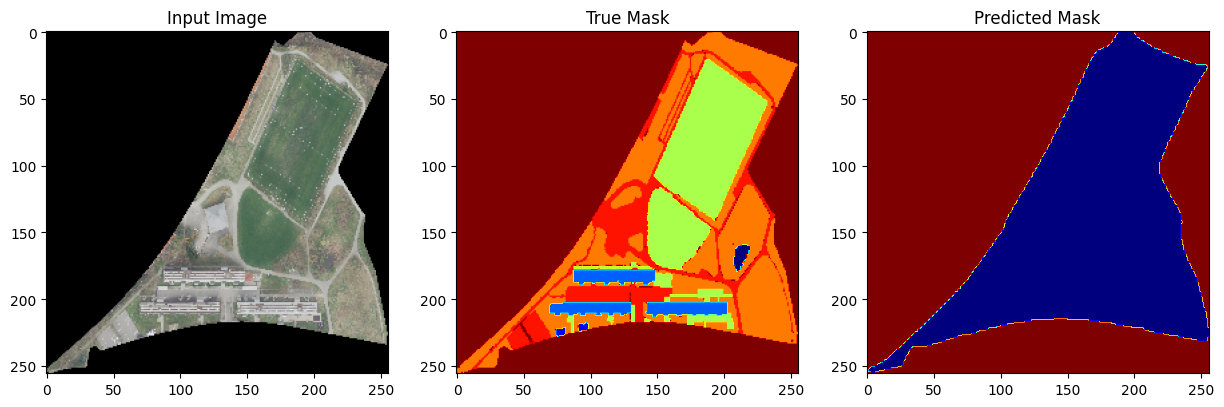

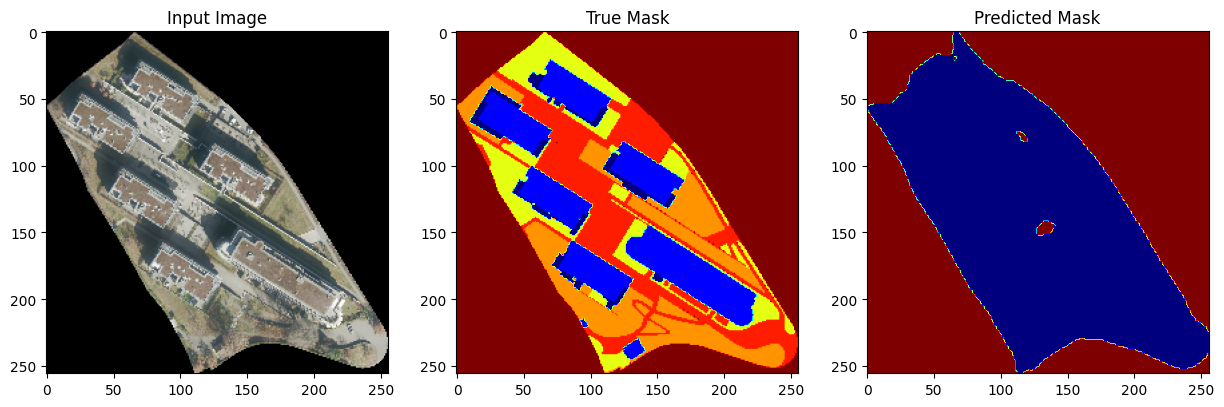

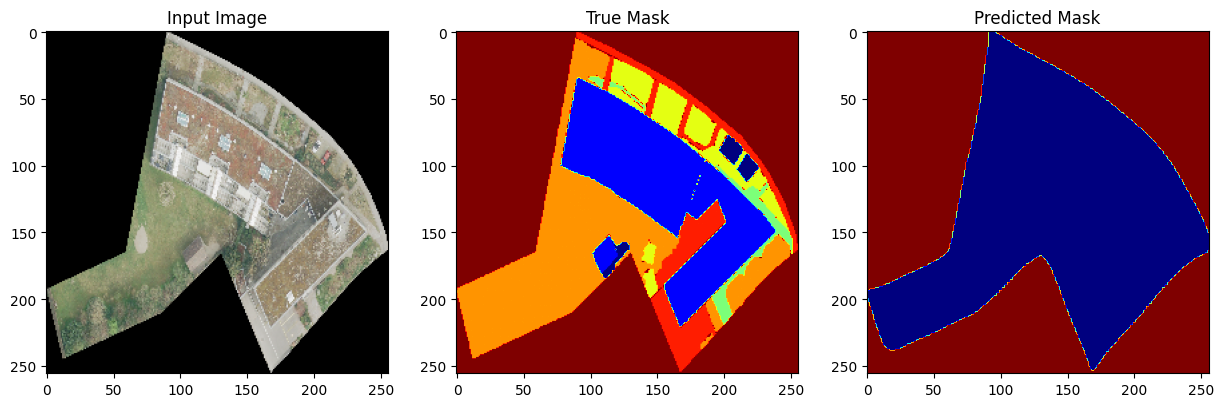

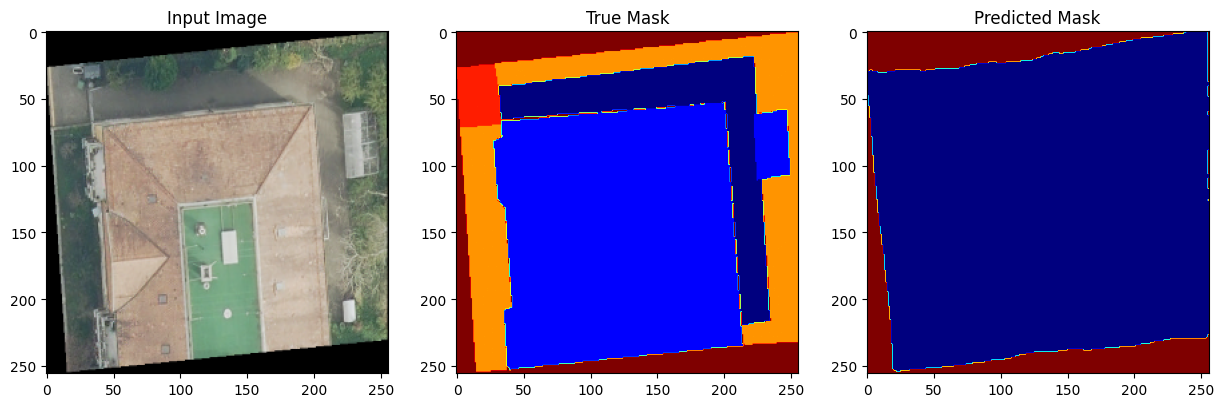

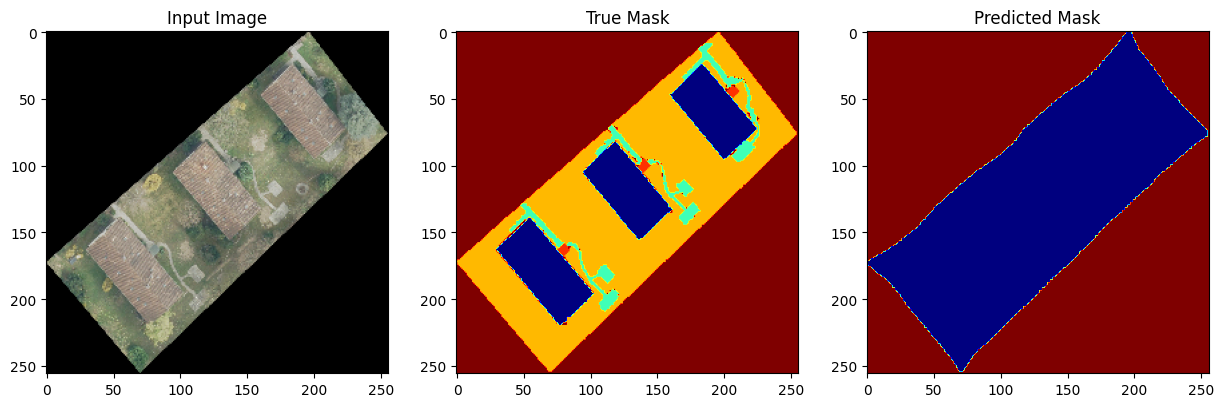

In [ ]:
# Visualize predictions
import matplotlib.pyplot as plt

for images, masks in val_dataset.take(1):  # Take one batch from the validation dataset
    predictions = unet_model.predict(images)
    predictions = tf.argmax(predictions, axis=-1)  # Convert one-hot predictions to class indices
    masks = tf.argmax(masks, axis=-1)  # Convert one-hot masks to class indices

    for i in range(5):  # Show 5 images from the batch
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.title("Input Image")
        plt.imshow(images[i].numpy()[:, :, :3])  # Show RGB channels only
        plt.subplot(1, 3, 2)
        plt.title("True Mask")
        plt.imshow(masks[i].numpy(), cmap='jet')
        plt.subplot(1, 3, 3)
        plt.title("Predicted Mask")
        plt.imshow(predictions[i].numpy(), cmap='jet')
        plt.show()


# U Net Experimente

In [ ]:
pip install pyDOE2


  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE2: filename=pyDOE2-1.3.0-py3-none-any.whl size=25524 sha256=870b88a30fc39642df898e59622a3e2b81ad391bb6d2bfd2f0581532517ac6e8
  Stored in directory: /root/.cache/pip/wheels/46/1f/29/6fda5c72f950841e39147ae603780ee913a62f977b4ad47ee4
Successfully built pyDOE2


## Setup Taguchi Method

### Hyperparameter definieren

In [ ]:
# Definiere die Levels (Werte) für jeden Faktor
learning_rates = [0.001, 0.0005]  # 2 Levels
batch_sizes = [16, 32]            # 2 Levels
dropout_rates = [0.1, 0.3]        # 2 Levels
filter_sizes = [32, 64]           # 2 Levels
optimizers = ["adam", "sgd"]      # 2 Levels

# Mapping der Levels zu Faktoren
parameter_mapping = [learning_rates, batch_sizes, dropout_rates, filter_sizes, optimizers]

# Manuelles \(L_8\)-orthogonales Array
orthogonal_array = [
    [0, 0, 0, 0, 0],
    [0, 0, 1, 1, 1],
    [0, 1, 0, 0, 1],
    [0, 1, 1, 1, 0],
    [1, 0, 0, 1, 0],
    [1, 0, 1, 0, 1],
    [1, 1, 0, 1, 1],
    [1, 1, 1, 0, 0]
]

# Übersetze die orthogonalen Array-Werte (0/1) in die tatsächlichen Hyperparameter
experiments = []
for row in orthogonal_array:
    config = {}
    for factor_index, level_index in enumerate(row):
        # Hole den Parametername und die zugehörigen Werte aus der Liste
        param_name = ["lr", "batch_size", "dropout_rate", "filters", "optimizer"][factor_index]
        param_values = parameter_mapping[factor_index]  # Werte für diesen Faktor
        config[param_name] = param_values[level_index]  # Mapping 0 oder 1 auf die Werte
    experiments.append(config)

# Ausgabe der generierten Experimente
print(f"Generierte Experimente ({len(experiments)}):")
for exp in experiments:
    print(exp)



Generierte Experimente (8):
{'lr': 0.001, 'batch_size': 16, 'dropout_rate': 0.1, 'filters': 32, 'optimizer': 'adam'}
{'lr': 0.001, 'batch_size': 16, 'dropout_rate': 0.3, 'filters': 64, 'optimizer': 'sgd'}
{'lr': 0.001, 'batch_size': 32, 'dropout_rate': 0.1, 'filters': 32, 'optimizer': 'sgd'}
{'lr': 0.001, 'batch_size': 32, 'dropout_rate': 0.3, 'filters': 64, 'optimizer': 'adam'}
{'lr': 0.0005, 'batch_size': 16, 'dropout_rate': 0.1, 'filters': 64, 'optimizer': 'adam'}
{'lr': 0.0005, 'batch_size': 16, 'dropout_rate': 0.3, 'filters': 32, 'optimizer': 'sgd'}
{'lr': 0.0005, 'batch_size': 32, 'dropout_rate': 0.1, 'filters': 64, 'optimizer': 'sgd'}
{'lr': 0.0005, 'batch_size': 32, 'dropout_rate': 0.3, 'filters': 32, 'optimizer': 'adam'}


### Data Load and Preperation

In [ ]:
# Step 1: Read the labelmap
labelmap = {}
with open(labelmap_path, "r") as file:
    for line in file:
        if not line.startswith("#") and line.strip():  # Ignore comments and empty lines
            label, color_rgb, *_ = line.split(":")
            r, g, b = map(int, color_rgb.split(","))
            labelmap[(r, g, b)] = label

# Create a reverse mapping from colors to class indices
color_to_index = {color: i for i, color in enumerate(labelmap.keys())}
num_classes = len(color_to_index)

# Step 2: Functions to preprocess raster images and masks
def load_raster_image(filepath):
    """
    Load and preprocess a single raster image (TIFF with RGBI channels).
    Handles TensorFlow string tensors correctly.
    """
    # Convert TensorFlow tensor to Python string if necessary
    if isinstance(filepath, tf.Tensor):
        filepath = filepath.numpy().decode("utf-8")  # Decode TensorFlow string tensor to Python string

    with rasterio.open(filepath) as src:
        # Read all bands (assume RGBA or RGBI)
        image = np.stack([src.read(i) for i in range(1, src.count + 1)], axis=-1)
        # Normalize image to range [0, 1]
        image = image.astype(np.float32) / 255.0
    return image


def convert_mask_to_labels(mask, color_to_index):
    """
    Convert a segmentation mask from RGB colors to integer class labels.
    """
    # Flatten the mask into a list of pixels
    mask_flat = mask.reshape(-1, 3)

    # Map each RGB color to its corresponding class index
    label_flat = np.zeros(mask_flat.shape[0], dtype=np.int32)
    for color, index in color_to_index.items():
        matches = np.all(mask_flat == color, axis=1)
        label_flat[matches] = index

    # Reshape back to the original mask dimensions
    label_mask = label_flat.reshape(mask.shape[:2])
    return label_mask

def load_mask(filepath):
    """
    Load a mask (PNG) and convert it to class labels using the color-to-index mapping.
    """
    # Convert TensorFlow tensor to Python string if necessary
    if isinstance(filepath, tf.Tensor):
        filepath = filepath.numpy().decode("utf-8")  # Decode TensorFlow string tensor to Python string

    # Load the mask as an RGB image
    mask = tf.io.read_file(filepath)
    mask = tf.image.decode_png(mask, channels=3).numpy()  # Convert to NumPy array

    # Map the RGB values to class indices
    label_mask = np.zeros(mask.shape[:2], dtype=np.int32)  # Create an empty label mask
    for color, index in color_to_index.items():
        matches = np.all(mask == color, axis=-1)
        label_mask[matches] = index

    return label_mask



def preprocess_image_and_mask(image_path, mask_path, target_size, color_to_index):
    """
    Preprocess both the image and the mask: resizing, normalization, and converting masks to labels.
    """
    # Load the raster image using tf.py_function
    image = tf.py_function(func=load_raster_image, inp=[image_path], Tout=tf.float32)
    image.set_shape([None, None, 4])  # Explicitly set shape for TensorFlow (height, width, 4 channels)

    # Resize the image
    image = tf.image.resize(image, target_size, method='bilinear')

    # Load and preprocess the mask using tf.py_function
    mask = tf.py_function(func=load_mask, inp=[mask_path], Tout=tf.int32)  # Return as integer labels
    mask.set_shape([None, None])  # Explicitly set shape for TensorFlow (height, width)
    mask = tf.image.resize(mask[..., tf.newaxis], target_size, method='nearest')  # Resize with nearest-neighbor
    mask = tf.squeeze(mask)  # Remove channel dimension
    mask = to_categorical(mask, num_classes=len(color_to_index))  # One-hot encode the mask

    return image, mask



### Create TF dataset

In [ ]:
# Step 3: Create TensorFlow datasets
def create_dataset(image_paths, mask_paths, batch_size, target_size, color_to_index):
    """
    Create a tf.data.Dataset for images and masks, including labelmap processing.
    """
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))

    def _preprocess(image_path, mask_path):
        image, mask = preprocess_image_and_mask(image_path, mask_path, target_size, color_to_index)
        image.set_shape([target_size[0], target_size[1], 4])  # Set shape explicitly for images
        mask.set_shape([target_size[0], target_size[1], len(color_to_index)])  # Set shape explicitly for masks
        return image, mask

    dataset = dataset.map(_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Step 4: File preparation
# Get file paths for all raster images and masks
raster_files = sorted(glob.glob(f"{raster_path}/*.tif"))
mask_files = sorted(glob.glob(f"{mask_path}/*.png"))

# Ensure matching number of images and masks
assert len(raster_files) == len(mask_files), "Mismatch between raster and mask files!"

# Split data into training and validation sets
train_size = int(0.8 * len(raster_files))
train_raster_files = raster_files[:train_size]
train_mask_files = mask_files[:train_size]
val_raster_files = raster_files[train_size:]
val_mask_files = mask_files[train_size:]

### Prepare Dataset

In [ ]:
def prepare_experiment_data(image_paths, mask_paths, target_size, color_to_index):
    """
    Prepare tf.data.Dataset for experiments without applying batching.
    """
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))

    def preprocess_experiment_data(image_path, mask_path):
        image, mask = preprocess_image_and_mask(image_path, mask_path, target_size, color_to_index)
        return image, mask

    dataset = dataset.map(preprocess_experiment_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset



In [ ]:
# Prepare unbatched datasets for experiments
experiment_train_data = prepare_experiment_data(train_raster_files, train_mask_files, image_size, color_to_index)
experiment_val_data = prepare_experiment_data(val_raster_files, val_mask_files, image_size, color_to_index)


### Modellaufbau

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, concatenate
from tensorflow.keras.models import Model

def build_dynamic_unet(input_shape, num_classes, filters, dropout_rate):
    """
    Build a U-Net model dynamically with hyperparameters.
    """
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(filters, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Dropout(dropout_rate)(c1)
    c1 = Conv2D(filters, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(filters * 2, (3, 3), activation='relu', padding='same')(p1)
    c2 = Dropout(dropout_rate)(c2)
    c2 = Conv2D(filters * 2, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(filters * 4, (3, 3), activation='relu', padding='same')(p2)
    c3 = Dropout(dropout_rate)(c3)
    c3 = Conv2D(filters * 4, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = Conv2D(filters * 8, (3, 3), activation='relu', padding='same')(p3)
    c4 = Dropout(dropout_rate)(c4)
    c4 = Conv2D(filters * 8, (3, 3), activation='relu', padding='same')(c4)

    # Decoder
    u5 = UpSampling2D((2, 2))(c4)
    u5 = concatenate([u5, c3])
    c5 = Conv2D(filters * 4, (3, 3), activation='relu', padding='same')(u5)
    c5 = Conv2D(filters * 4, (3, 3), activation='relu', padding='same')(c5)

    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(filters * 2, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(filters * 2, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(filters, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(filters, (3, 3), activation='relu', padding='same')(c7)

    # Output Layer
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c7)

    return Model(inputs, outputs)


## Taguchi Method - Experimente durchführen ohne Weights

In [ ]:
def run_taguchi_experiment(config, unbatched_train_data, unbatched_val_data, input_shape, num_classes):
    """
    Führt ein einzelnes Experiment mit den Hyperparametern durch.
    """
    print(f"Running experiment with config: {config}")

    # Dynamisches U-Net-Modell erstellen
    experiment_model = build_dynamic_unet(
        input_shape=input_shape,
        num_classes=num_classes,
        filters=config["filters"],
        dropout_rate=config["dropout_rate"]
    )

    # Optimizer konfigurieren
    optimizer = tf.keras.optimizers.Adam(learning_rate=config["lr"]) if config["optimizer"] == "adam" else tf.keras.optimizers.SGD(learning_rate=config["lr"])

    # Modell kompilieren
    experiment_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Batch-Größe anwenden
    train_data = unbatched_train_data.batch(config["batch_size"])
    val_data = unbatched_val_data.batch(config["batch_size"])

    # Modell trainieren
    history = experiment_model.fit(
        train_data,
        validation_data=val_data,
        epochs=10,  # Für die ersten Tests begrenzt
        verbose=1
    )

    # Ergebnisse auswerten
    val_loss, val_accuracy = experiment_model.evaluate(val_data, verbose=0)
    return val_loss, val_accuracy


### Experiment iterieren

In [ ]:
experiment_results = []

for i, config in enumerate(experiments):
    val_loss, val_accuracy = run_taguchi_experiment(
        config=config,
        unbatched_train_data=experiment_train_data,
        unbatched_val_data=experiment_val_data,
        input_shape=(256, 256, 4),
        num_classes=11
    )

    experiment_results.append({
        "experiment": i + 1,
        "config": config,
        "val_loss": val_loss,
        "val_accuracy": val_accuracy
    })

print("All experiments completed.")


Running experiment with config: {'lr': 0.001, 'batch_size': 16, 'dropout_rate': 0.1, 'filters': 32, 'optimizer': 'adam'}
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 41s 41s/step - accuracy: 0.0828 - loss: 2.3927 - val_accuracy: 0.1911 - val_loss: 2.3475
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - accuracy: 0.1522 - loss: 2.3376 - val_accuracy: 0.1927 - val_loss: 2.1755
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step - accuracy: 0.1520 - loss: 2.1267 - val_accuracy: 0.1909 - val_loss: 2.6938
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step - accuracy: 0.2527 - loss: 3.7806 - val_accuracy: 0.2046 - val_loss: 2.0818
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - accuracy: 0.1655 - loss: 2.0318 - val_accuracy: 0.5780 - val_loss: 2.2177
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step - accuracy: 0.4210 - loss: 2.1885 - val_accuracy: 0.6031 - val_loss: 2.2580
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step - accuracy: 0.4423 - loss: 2.2365 - val_accuracy: 0.6180 - val_loss: 2.2645
Epoc

Ergebnisse:
Experiment,Learning Rate,Batch Size,Dropout Rate,Filters,Optimizer,Validation Accuracy,Validation Loss
1,0.001,16,0.1,32,adam,0.1911,2.3475
2,0.001,16,0.3,64,sgd,0.3006,2.4139
3,0.001,32,0.1,32,sgd,0.2833,2.3804
4,0.001,32,0.3,64,adam,0.1880,2.2233
5,0.0005,16,0.1,64,adam,0.2035,2.3438
6,0.0005,16,0.3,32,sgd,0.2977,2.4056
7,0.0005,32,0.1,64,sgd,0.2239,2.4024
8,0.0005,32,0.3,32,adam,0.2651,2.3882


#### Analyse der Ergebnisse

In [ ]:
import pandas as pd

# CSV-Datei einlesen
summary_path = "/content/drive/MyDrive/U-Net_experiments.csv"
df_results = pd.read_csv(summary_path)

df_results

,Experiment,Learning Rate,Batch Size,Dropout Rate,Filters,Optimizer,Validation Accuracy,Validation Loss
0,1,0.0010,16,0.1,32,adam,0.1911,2.3475
1,2,0.0010,16,0.3,64,sgd,0.3006,2.4139
2,3,0.0010,32,0.1,32,sgd,0.2833,2.3804
3,4,0.0010,32,0.3,64,adam,0.1880,2.2233
4,5,0.0005,16,0.1,64,adam,0.2035,2.3438
5,6,0.0005,16,0.3,32,sgd,0.2977,2.4056
6,7,0.0005,32,0.1,64,sgd,0.2239,2.4024
7,8,0.0005,32,0.3,32,adam,0.2651,2.3882


In [ ]:
import pandas as pd

# CSV-Datei einlesen
summary_path = "/content/drive/MyDrive/U-Net_experiments.csv"
df_results = pd.read_csv(summary_path)

# Bestes Experiment basierend auf Validation Accuracy
best_experiment = df_results.loc[df_results["Validation Accuracy"].idxmax()]
print("Bestes Experiment basierend auf Validation Accuracy:\n", best_experiment)

# Alternativ: Bestes Experiment basierend auf Validation Loss
best_experiment_loss = df_results.loc[df_results["Validation Loss"].idxmin()]
print("Bestes Experiment basierend auf Validation Loss:\n", best_experiment_loss)

Bestes Experiment basierend auf Validation Accuracy:
 Experiment                  2
Learning Rate           0.001
Batch Size                 16
Dropout Rate              0.3
Filters                    64
Optimizer                 sgd
Validation Accuracy    0.3006
Validation Loss        2.4139
Name: 1, dtype: object
Bestes Experiment basierend auf Validation Loss:
 Experiment                  4
Learning Rate           0.001
Batch Size                 32
Dropout Rate              0.3
Filters                    64
Optimizer                adam
Validation Accuracy     0.188
Validation Loss        2.2233
Name: 3, dtype: object


### Erneuter Durchlauf von Experiment 2 und 4

hier erneuter Durchlauf mit 10 statt 11 Klassen. Labelmap wurde angepasst von 11 auf 10 Klassen, "keine Zuordnung" wurd gelöscht. Dadurch hat sich die Labelmap geändert im Vergleich zu den vorherigen Modelltrainings

In [ ]:
def train_fixed_model(config, train_data, val_data, input_shape, num_classes, epochs=20):
    """
    Trainiert ein Modell mit einer fixen Konfiguration.
    """
    print(f"Training Model for Experiment {config['id']} with config: {config}")

    # Modell erstellen
    model = build_dynamic_unet(
        input_shape=input_shape,
        num_classes=num_classes,
        filters=config["filters"],
        dropout_rate=config["dropout_rate"]
    )

    # Optimizer einstellen
    optimizer = tf.keras.optimizers.Adam(learning_rate=config["lr"]) if config["optimizer"] == "adam" else tf.keras.optimizers.SGD(learning_rate=config["lr"])
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Daten batchen
    train_ds = train_data.batch(config["batch_size"]).prefetch(tf.data.AUTOTUNE)
    val_ds = val_data.batch(config["batch_size"]).prefetch(tf.data.AUTOTUNE)

    # Training
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=1)

    # Validierungsergebnisse evaluieren
    val_loss, val_accuracy = model.evaluate(val_ds, verbose=0)
    print(f"Experiment {config['id']} - Val Loss: {val_loss}, Val Accuracy: {val_accuracy}")

    return model, val_loss, val_accuracy


In [ ]:
def save_predictions(model, val_data, save_path):
    """
    Speichert die Vorhersagen und Ground-Truth-Daten.
    """
    predictions = []
    ground_truths = []

    for images, masks in val_data:
        preds = model.predict(images)
        predictions.extend(tf.argmax(preds, axis=-1).numpy().flatten())
        ground_truths.extend(tf.argmax(masks, axis=-1).numpy().flatten())

    np.savez(save_path, predictions=np.array(predictions), ground_truths=np.array(ground_truths))
    print(f"Predictions saved at {save_path}")


In [ ]:
# Konfigurationen für die beiden Experimente
experiment_configs = [
    {"id": 2, "lr": 0.001, "batch_size": 16, "dropout_rate": 0.3, "filters": 64, "optimizer": "sgd"},
    {"id": 4, "lr": 0.001, "batch_size": 32, "dropout_rate": 0.3, "filters": 64, "optimizer": "adam"}
]

# Ergebnisse initialisieren
results = []

# Training für beide Experimente
for config in experiment_configs:
    model, val_loss, val_accuracy = train_fixed_model(
        config=config,
        train_data=experiment_train_data,
        val_data=experiment_val_data,
        input_shape=(256, 256, 4),
        num_classes=10,
        epochs=20
    )

    # Ergebnisse speichern
    results.append({
        "experiment": config["id"],
        "val_loss": val_loss,
        "val_accuracy": val_accuracy
    })

    # Predictions speichern
    save_path = f"/content/drive/MyDrive/unet_experiment_{config['id']}_predictions.npz"
    save_predictions(model, experiment_val_data.batch(config["batch_size"]), save_path)

# Ergebnisse ausgeben
print("Experiments completed. Results:")
for result in results:
    print(result)


Training Model for Experiment 2 with config: {'id': 2, 'lr': 0.001, 'batch_size': 16, 'dropout_rate': 0.3, 'filters': 64, 'optimizer': 'sgd'}
Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step - accuracy: 0.0527 - loss: 2.3049 - val_accuracy: 0.3319 - val_loss: 2.3041
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - accuracy: 0.1889 - loss: 2.3042 - val_accuracy: 0.3750 - val_loss: 2.3035
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - accuracy: 0.2234 - loss: 2.3036 - val_accuracy: 0.3969 - val_loss: 2.3029
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - accuracy: 0.2471 - loss: 2.3030 - val_accuracy: 0.4098 - val_loss: 2.3023
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - accuracy: 0.2648 - loss: 2.3024 - val_accuracy: 0.4188 - val_loss: 2.3017
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - accuracy: 0.2780 - loss: 2.3017 - val_accuracy: 0.4257 - val_loss: 2.3011
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - accuracy: 0.2895 - loss: 2.3011 - val_accuracy: 0.4317 - 

Experiment 4 ist insgesamt das leistungsstärkere Modell, basierend auf:
Höherer Validation Accuracy.
Niedrigerem Validation Loss.
Der Adam-Optimizer und Batch Size 32 scheinen effektiver für dieses Problem zu sein.

In [ ]:
import pandas as pd

# Ergebnisse der Experimente
results = [
    {
        "Experiment_ID": 2,
        "Learning_Rate": 0.001,
        "Batch_Size": 16,
        "Dropout_Rate": 0.3,
        "Filters": 64,
        "Optimizer": "sgd",
        "Validation_Loss": 2.2926,  # Gerundet auf 4 Dezimalstellen
        "Validation_Accuracy": 0.4571
    },
    {
        "Experiment_ID": 4,
        "Learning_Rate": 0.001,
        "Batch_Size": 32,
        "Dropout_Rate": 0.3,
        "Filters": 64,
        "Optimizer": "adam",
        "Validation_Loss": 1.0919,  # Gerundet auf 4 Dezimalstellen
        "Validation_Accuracy": 0.6036
    }
]

# Ergebnisse in DataFrame konvertieren
df_results = pd.DataFrame(results)

# CSV speichern
results_path = "/content/drive/MyDrive/unet_experiment_results_2_4.csv"
df_results.to_csv(results_path, index=False)
print(f"Ergebnisse gespeichert unter: {results_path}")


Ergebnisse gespeichert unter: /content/drive/MyDrive/unet_experiment_results_2_4.csv


### Analyse

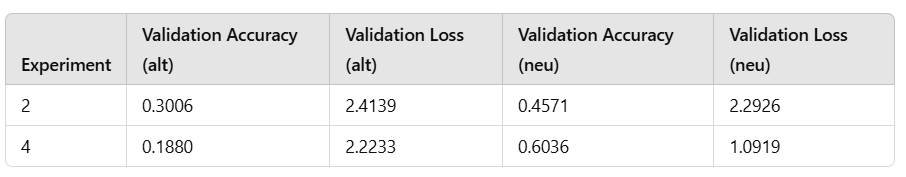

* Beste Validierungsgenauigkeit bisher: Experiment 4 hat mit 60.36% die höchste Accuracy unter allen Experimenten erreicht.
* Niedrigster Validation Loss bisher: Experiment 4 zeigt mit 1.0919 ebenfalls den niedrigsten Loss, was auf eine gute Balance zwischen Training und Generalisierung hinweist.

**Schlüsselbeobachtungen**:
* Adam-Optimizer: Funktioniert besser als SGD in Experiment 4. Dies zeigt, dass Adam effektiver bei der Anpassung an die Daten ist.
* Batch Size 32: Liefert stabilere Ergebnisse in Kombination mit dem Adam-Optimizer.
* Dropout Rate: Die moderate Dropout Rate von 0.3 scheint in diesem Fall sinnvoll zu sein, da sie Overfitting verhindert.

Classification Report:
              precision    recall  f1-score   support

     Class 1       0.00      0.00      0.00       143
     Class 2       0.00      0.00      0.00     11074
     Class 3       0.34      0.67      0.45     61605
     Class 5       0.00      0.00      0.00     10911
     Class 6       0.00      0.00      0.00      8782
     Class 7       0.18      0.10      0.13     63081
     Class 8       0.00      0.00      0.00     20282
     Class 9       0.87      0.99      0.93    151802

    accuracy                           0.60    327680
   macro avg       0.17      0.22      0.19    327680
weighted avg       0.50      0.60      0.54    327680



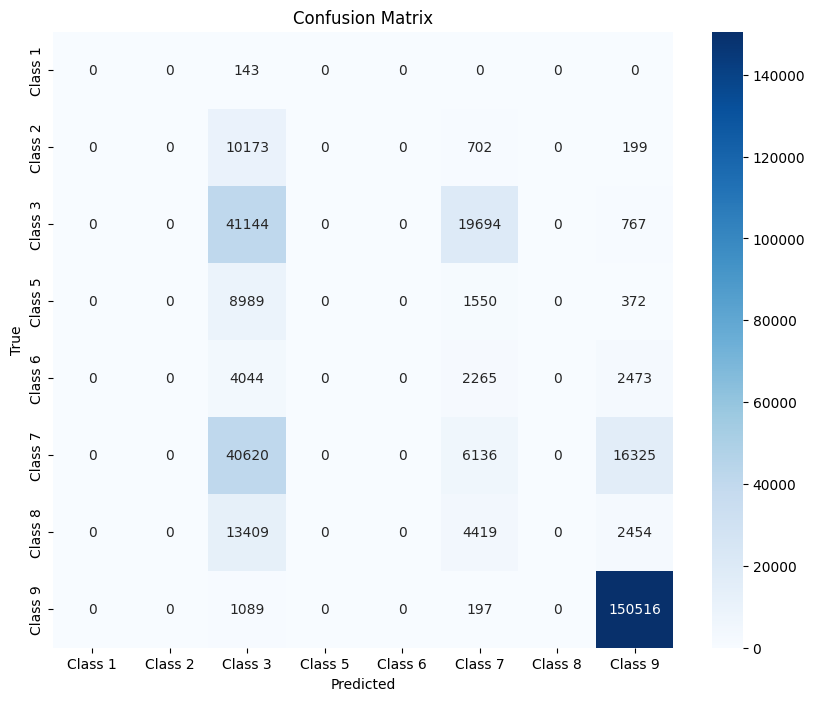

IoU Scores:
Class 1: 0.00
Class 2: 0.00
Class 3: 0.29
Class 5: 0.00
Class 6: 0.00
Class 7: 0.07
Class 8: 0.00
Class 9: 0.86


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Daten laden
prediction_path = "/content/drive/MyDrive/unet_experiment_4_predictions.npz"
data = np.load(prediction_path)
y_pred = data["predictions"]
y_true = data["ground_truths"]

# Dynamische Klassenanpassung
present_classes = sorted(set(y_true).union(set(y_pred)))
num_present_classes = len(present_classes)
class_names = [f"Class {i}" for i in present_classes]

# Confusion Matrix berechnen
cm = confusion_matrix(y_true, y_pred, labels=present_classes)

# Klassifikationsbericht
print("Classification Report:")
report = classification_report(
    y_true,
    y_pred,
    labels=present_classes,
    target_names=class_names,
    zero_division=0
)
print(report)

# Konfusionsmatrix visualisieren
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# IoU berechnen
def calculate_iou(cm):
    iou_scores = []
    for i in range(len(cm)):
        true_positive = cm[i, i]
        false_positive = cm[:, i].sum() - true_positive
        false_negative = cm[i, :].sum() - true_positive
        union = true_positive + false_positive + false_negative
        iou = true_positive / union if union > 0 else 0
        iou_scores.append(iou)
    return iou_scores

iou_scores = calculate_iou(cm)
print("IoU Scores:")
for i, score in enumerate(iou_scores):
    print(f"{class_names[i]}: {score:.2f}")


In [ ]:
print("Index to Label Mapping:")
for idx, label in index_to_label.items():
    print(f"Index {idx}: {label}")


Index to Label Mapping:
Index 0: background
Index 1: background
Index 2: background
Index 3: background
Index 4: background
Index 5: background
Index 6: background
Index 7: background
Index 8: background
Index 9: background


In [ ]:
print("Unique values in y_true:", np.unique(y_true))
print("Unique values in y_pred:", np.unique(y_pred))


Unique values in y_true: [1 2 3 5 6 7 8 9]
Unique values in y_pred: [3 7 9]


Index to Label Mapping (Fixed):
Index 0: Begrünte Belagsfläche
Index 1: Blaue Fläche
Index 2: Durchlässige Belagsfläche
Index 3: Gebäude
Index 4: Gebäudebegrünungen
Index 5: Teilversiegelte Belagsfläche
Index 6: Vegetationsfläche
Index 7: Vegetationsfläche mit Bodenanschluss
Index 8: Versiegelte Belagsfläche
Index 9: background
Classification Report:
                                      precision    recall  f1-score   support

                        Blaue Fläche       0.00      0.00      0.00       143
           Durchlässige Belagsfläche       0.00      0.00      0.00     11074
                             Gebäude       0.34      0.67      0.45     61605
        Teilversiegelte Belagsfläche       0.00      0.00      0.00     10911
                   Vegetationsfläche       0.00      0.00      0.00      8782
Vegetationsfläche mit Bodenanschluss       0.18      0.10      0.13     63081
            Versiegelte Belagsfläche       0.00      0.00      0.00     20282
                      

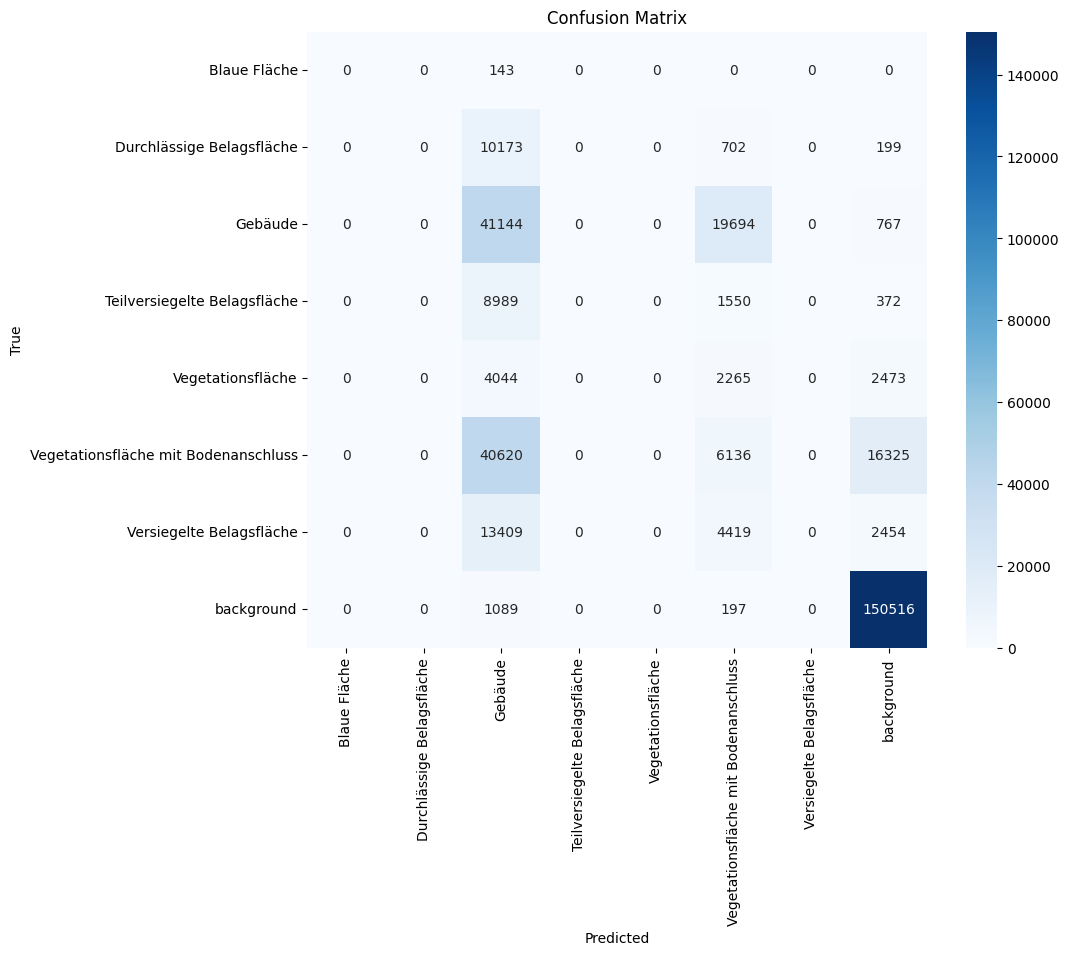

IoU Scores:
Blaue Fläche: 0.00
Durchlässige Belagsfläche: 0.00
Gebäude: 0.29
Teilversiegelte Belagsfläche: 0.00
Vegetationsfläche: 0.00
Vegetationsfläche mit Bodenanschluss: 0.07
Versiegelte Belagsfläche: 0.00
background: 0.86


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Daten laden
prediction_path = "/content/drive/MyDrive/unet_experiment_4_predictions.npz"
data = np.load(prediction_path)
y_pred = data["predictions"]
y_true = data["ground_truths"]

# Korrekte Mapping-Erstellung aus der Labelmap
index_to_label = {index: label for index, label in enumerate(labelmap.values())}

# Überprüfung des korrekten Mappings
print("Index to Label Mapping (Fixed):")
for idx, label in index_to_label.items():
    print(f"Index {idx}: {label}")


# Dynamische Klassenanpassung basierend auf den vorhandenen Klassen
present_classes = sorted(set(y_true).union(set(y_pred)))
num_present_classes = len(present_classes)
class_names = [index_to_label[i] for i in present_classes]

# Confusion Matrix berechnen
cm = confusion_matrix(y_true, y_pred, labels=present_classes)

# Klassifikationsbericht
print("Classification Report:")
report = classification_report(
    y_true,
    y_pred,
    labels=present_classes,
    target_names=class_names,
    zero_division=0
)
print(report)

# Konfusionsmatrix visualisieren
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# IoU berechnen
def calculate_iou(cm):
    iou_scores = []
    for i in range(len(cm)):
        true_positive = cm[i, i]
        false_positive = cm[:, i].sum() - true_positive
        false_negative = cm[i, :].sum() - true_positive
        union = true_positive + false_positive + false_negative
        iou = true_positive / union if union > 0 else 0
        iou_scores.append(iou)
    return iou_scores

iou_scores = calculate_iou(cm)
print("IoU Scores:")
for i, score in enumerate(iou_scores):
    print(f"{class_names[i]}: {score:.2f}")


In [ ]:
unique, counts = np.unique(y_true, return_counts=True)
print("Class distribution in y_true:", dict(zip(unique, counts)))

unique_pred, counts_pred = np.unique(y_pred, return_counts=True)
print("Class distribution in y_pred:", dict(zip(unique_pred, counts_pred)))


Class distribution in y_true: {1: 143, 2: 11074, 3: 61605, 5: 10911, 6: 8782, 7: 63081, 8: 20282, 9: 151802}
Class distribution in y_pred: {3: 119611, 7: 34963, 9: 173106}


## Taguchi Method - mit Gewichtungen sowie Speichern der Predictions

In [ ]:
# Übersetze die orthogonalen Array-Werte (0/1) in die tatsächlichen Hyperparameter mit ID
experiments = []
for idx, row in enumerate(orthogonal_array, start=1):  # Startet die ID bei 1
    config = {"id": idx}  # Füge die ID hinzu
    for factor_index, level_index in enumerate(row):
        # Hole den Parametername und die zugehörigen Werte aus der Liste
        param_name = ["lr", "batch_size", "dropout_rate", "filters", "optimizer"][factor_index]
        param_values = parameter_mapping[factor_index]  # Werte für diesen Faktor
        config[param_name] = param_values[level_index]  # Mapping 0 oder 1 auf die Werte
    experiments.append(config)

# Ausgabe der generierten Experimente mit IDs
print(f"Generierte Experimente ({len(experiments)}):")
for exp in experiments:
    print(exp)


Generierte Experimente (8):
{'id': 1, 'lr': 0.001, 'batch_size': 16, 'dropout_rate': 0.1, 'filters': 32, 'optimizer': 'adam'}
{'id': 2, 'lr': 0.001, 'batch_size': 16, 'dropout_rate': 0.3, 'filters': 64, 'optimizer': 'sgd'}
{'id': 3, 'lr': 0.001, 'batch_size': 32, 'dropout_rate': 0.1, 'filters': 32, 'optimizer': 'sgd'}
{'id': 4, 'lr': 0.001, 'batch_size': 32, 'dropout_rate': 0.3, 'filters': 64, 'optimizer': 'adam'}
{'id': 5, 'lr': 0.0005, 'batch_size': 16, 'dropout_rate': 0.1, 'filters': 64, 'optimizer': 'adam'}
{'id': 6, 'lr': 0.0005, 'batch_size': 16, 'dropout_rate': 0.3, 'filters': 32, 'optimizer': 'sgd'}
{'id': 7, 'lr': 0.0005, 'batch_size': 32, 'dropout_rate': 0.1, 'filters': 64, 'optimizer': 'sgd'}
{'id': 8, 'lr': 0.0005, 'batch_size': 32, 'dropout_rate': 0.3, 'filters': 32, 'optimizer': 'adam'}


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# Funktion zur Berechnung der Klassengewichte
def calculate_class_weights(masks, num_classes):
    """
    Berechnet Gewichte basierend auf der Verteilung der Klassen.
    """
    class_counts = np.zeros(num_classes, dtype=np.int64)
    for mask in masks:
        unique, counts = np.unique(mask, return_counts=True)
        for cls, count in zip(unique, counts):
            if cls < num_classes:
                class_counts[cls] += count

    total_pixels = np.sum(class_counts)
    class_weights = total_pixels / (num_classes * class_counts)
    class_weights = np.where(class_counts == 0, 0, class_weights)
    return class_weights.astype(np.float32)

# Gewichtete Verlustfunktion
def weighted_categorical_crossentropy(class_weights):
    def loss(y_true, y_pred):
        y_true_indices = tf.argmax(y_true, axis=-1)
        weights = tf.gather(class_weights, y_true_indices)
        cce = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
        unweighted_loss = cce(y_true, y_pred)
        weighted_loss = weights * unweighted_loss
        return tf.reduce_mean(weighted_loss)
    return loss

# Vorhersagen und Ground-Truth speichern
def save_predictions_and_ground_truth(model, val_data, save_path):
    predictions = []
    ground_truths = []
    for images, masks in val_data:
        preds = model.predict(images)
        predictions.append(tf.argmax(preds, axis=-1).numpy())
        ground_truths.append(tf.argmax(masks, axis=-1).numpy())
    np.savez(save_path, predictions=np.array(predictions), ground_truths=np.array(ground_truths))
    print(f"Predictions and ground truths saved to {save_path}")

# Experiment durchführen und Ergebnisse speichern
def run_taguchi_experiment_with_weights(config, unbatched_train_data, unbatched_val_data, input_shape, num_classes, train_masks):
    """
    Führt ein einzelnes Experiment mit Gewichten durch.
    """
    print(f"Running experiment with config: {config}")

    # Dynamisches U-Net-Modell erstellen
    experiment_model = build_dynamic_unet(
        input_shape=input_shape,
        num_classes=num_classes,
        filters=config["filters"],
        dropout_rate=config["dropout_rate"]
    )

    # Optimizer konfigurieren
    optimizer = tf.keras.optimizers.Adam(learning_rate=config["lr"]) if config["optimizer"] == "adam" else tf.keras.optimizers.SGD(learning_rate=config["lr"])

    # Klassen-Gewichte berechnen
    class_weights = calculate_class_weights(train_masks, num_classes)

    # Gewichtete Verlustfunktion
    loss_fn = weighted_categorical_crossentropy(class_weights)

    # Modell kompilieren
    experiment_model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

    # Batch-Größe anwenden
    train_data = unbatched_train_data.batch(config["batch_size"])
    val_data = unbatched_val_data.batch(config["batch_size"])

    # Modell trainieren
    history = experiment_model.fit(
        train_data,
        validation_data=val_data,
        epochs=10,  # Für die ersten Tests begrenzt
        verbose=1
    )

    # Ergebnisse auswerten
    val_loss, val_accuracy = experiment_model.evaluate(val_data, verbose=0)

    # Vorhersagen und Ground-Truth speichern
    save_path = f"/content/drive/MyDrive/unet_experiment_{config['id']}_results_weights.npz"
    save_predictions_and_ground_truth(experiment_model, val_data, save_path)

    return val_loss, val_accuracy

# Ergebnisse initialisieren
experiment_results = []

for i, config in enumerate(experiments):
    # Masken für Klassengewichte vorbereiten
    train_masks_data = [load_mask(mask) for mask in train_mask_files]

    val_loss, val_accuracy = run_taguchi_experiment_with_weights(
        config=config,
        unbatched_train_data=experiment_train_data,
        unbatched_val_data=experiment_val_data,
        input_shape=(256, 256, 4),
        num_classes=num_classes,
        train_masks=train_masks_data
    )

    experiment_results.append({
        "experiment": i + 1,
        "config": config,
        "val_loss": val_loss,
        "val_accuracy": val_accuracy
    })

# Ergebnisse in CSV speichern
results_df = pd.DataFrame(experiment_results)
csv_path = "/content/drive/MyDrive/unet_experiments_results_weights.csv"
results_df.to_csv(csv_path, index=False)
print(f"Experiment results saved to {csv_path}")


Running experiment with config: {'id': 1, 'lr': 0.001, 'batch_size': 16, 'dropout_rate': 0.1, 'filters': 32, 'optimizer': 'adam'}
Epoch 1/10


<ipython-input-13-b8e5b1e34330>:19: RuntimeWarning: divide by zero encountered in divide
  class_weights = total_pixels / (num_classes * class_counts)


1/1 ━━━━━━━━━━━━━━━━━━━━ 28s 28s/step - accuracy: 0.0108 - loss: 2.0839 - val_accuracy: 0.0619 - val_loss: 1.7736
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - accuracy: 0.1289 - loss: 2.0252 - val_accuracy: 0.0618 - val_loss: 1.8504
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - accuracy: 0.1289 - loss: 3.0715 - val_accuracy: 0.0340 - val_loss: 1.7222
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - accuracy: 0.0168 - loss: 1.9838 - val_accuracy: 0.1907 - val_loss: 1.7763
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - accuracy: 0.2514 - loss: 2.0289 - val_accuracy: 0.1906 - val_loss: 1.7867
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - accuracy: 0.2529 - loss: 2.0369 - val_accuracy: 0.1883 - val_loss: 1.7883
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - accuracy: 0.2508 - loss: 2.0372 - val_accuracy: 0.1880 - val_loss: 1.7864
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - accuracy: 0.2507 - loss: 2.0341 - val_accuracy: 0.1880 - val_loss: 1.7815
Epoch 9/10


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step
Predictions and ground truths saved to /content/drive/MyDrive/unet_experiment_5_results_weights.npz
Running experiment with config: {'id': 6, 'lr': 0.0005, 'batch_size': 16, 'dropout_rate': 0.3, 'filters': 32, 'optimizer': 'sgd'}
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step - accuracy: 0.0152 - loss: 2.0806 - val_accuracy: 0.0334 - val_loss: 1.8043
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - accuracy: 0.0151 - loss: 2.0806 - val_accuracy: 0.0334 - val_loss: 1.8043
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - accuracy: 0.0152 - loss: 2.0806 - val_accuracy: 0.0334 - val_loss: 1.8043
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - accuracy: 0.0152 - loss: 2.0804 - val_accuracy: 0.0334 - val_loss: 1.8043
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - accuracy: 0.0153 - loss: 2.0803 - val_accuracy: 0.0334 - val_loss: 1.8042
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - accuracy: 0.0151 - loss: 2.0805 - val_accuracy: 0.0334 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
Predictions and ground truths saved to /content/drive/MyDrive/unet_experiment_6_results_weights.npz
Running experiment with config: {'id': 7, 'lr': 0.0005, 'batch_size': 32, 'dropout_rate': 0.1, 'filters': 64, 'optimizer': 'sgd'}
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 25s 25s/step - accuracy: 0.0829 - loss: 2.0787 - val_accuracy: 0.0942 - val_loss: 1.8212
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - accuracy: 0.0752 - loss: 2.0786 - val_accuracy: 0.0861 - val_loss: 1.8211
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - accuracy: 0.0716 - loss: 2.0785 - val_accuracy: 0.0788 - val_loss: 1.8210
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - accuracy: 0.0684 - loss: 2.0784 - val_accuracy: 0.0721 - val_loss: 1.8209
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - accuracy: 0.0653 - loss: 2.0783 - val_accuracy: 0.0670 - val_loss: 1.8208
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - accuracy: 0.0631 - loss: 2.0782 - val_accuracy: 0.0625 

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

def calculate_iou(y_true, y_pred, num_classes):
    """
    Berechnet die IoU (Intersection over Union) für jede Klasse.
    """
    iou_scores = {}
    for class_index in range(num_classes):
        # Berechne True Positive, False Positive und False Negative
        true_positive = np.sum((y_true == class_index) & (y_pred == class_index))
        false_positive = np.sum((y_true != class_index) & (y_pred == class_index))
        false_negative = np.sum((y_true == class_index) & (y_pred != class_index))

        # Berechne IoU
        union = true_positive + false_positive + false_negative
        iou = true_positive / union if union > 0 else 0
        iou_scores[f"Class {class_index}"] = iou

    mean_iou = np.mean(list(iou_scores.values()))
    return iou_scores, mean_iou

# Ergebnisse initialisieren
iou_results = []

# Pfad zu den gespeicherten Vorhersagen und Ground Truth
for experiment in range(1, 9):
    file_path = f"/content/drive/MyDrive/unet_experiment_{experiment}_results_weights.npz"

    # Lade Vorhersagen und Ground Truth
    data = np.load(file_path)
    y_true = data["ground_truths"].flatten()
    y_pred = data["predictions"].flatten()

    # Berechne IoU
    iou_scores, mean_iou = calculate_iou(y_true, y_pred, num_classes=num_classes)

    # Ergebnisse speichern
    iou_results.append({
        "Experiment": experiment,
        "IoU Scores": iou_scores,
        "Mean IoU": mean_iou
    })

# Ergebnisse anzeigen
for result in iou_results:
    print(f"Experiment {result['Experiment']}:")
    print(f"Class-Specific IoU: {result['IoU Scores']}")
    print(f"Mean IoU: {result['Mean IoU']:.2f}\n")


Experiment 1:
Class-Specific IoU: {'Class 0': 0, 'Class 1': 0.0, 'Class 2': 0.0, 'Class 3': 0.18802362312869111, 'Class 4': 0, 'Class 5': 0.0, 'Class 6': 0.0, 'Class 7': 0.0, 'Class 8': 0.0, 'Class 9': 0.0}
Mean IoU: 0.02

Experiment 2:
Class-Specific IoU: {'Class 0': 0.0, 'Class 1': 0.0, 'Class 2': 0.0, 'Class 3': 0.2039901601874988, 'Class 4': 0.0, 'Class 5': 0.0, 'Class 6': 0.0019428254232583958, 'Class 7': 0.0, 'Class 8': 0.0, 'Class 9': 0.005501414649481296}
Mean IoU: 0.02

Experiment 3:
Class-Specific IoU: {'Class 0': 0.0, 'Class 1': 0.00034847143476049653, 'Class 2': 0.0016390755613833797, 'Class 3': 8.31008488158129e-05, 'Class 4': 0.0, 'Class 5': 0.030345869793063106, 'Class 6': 0.0, 'Class 7': 3.139175338638539e-05, 'Class 8': 0.005717497480424839, 'Class 9': 0.0020552005796719585}
Mean IoU: 0.00

Experiment 4:
Class-Specific IoU: {'Class 0': 0, 'Class 1': 0.0, 'Class 2': 0.0, 'Class 3': 0.19106887535938813, 'Class 4': 0, 'Class 5': 0.0, 'Class 6': 0.0, 'Class 7': 0.0, 'Class

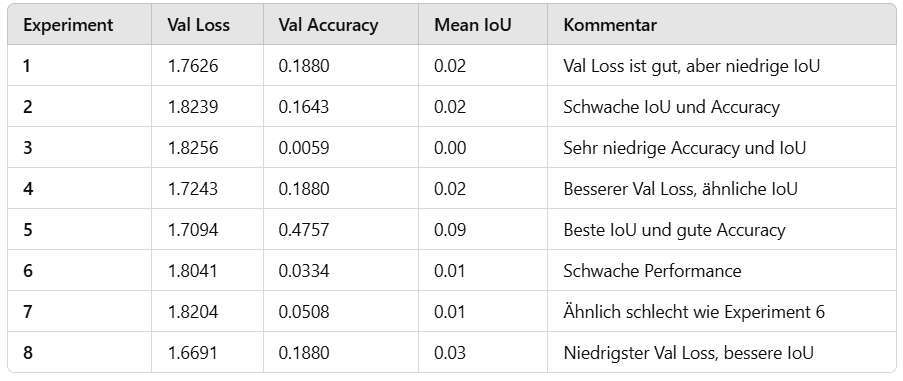

--> Experiment 5

### Analyse (Experiment 5 mit Gewichtung)

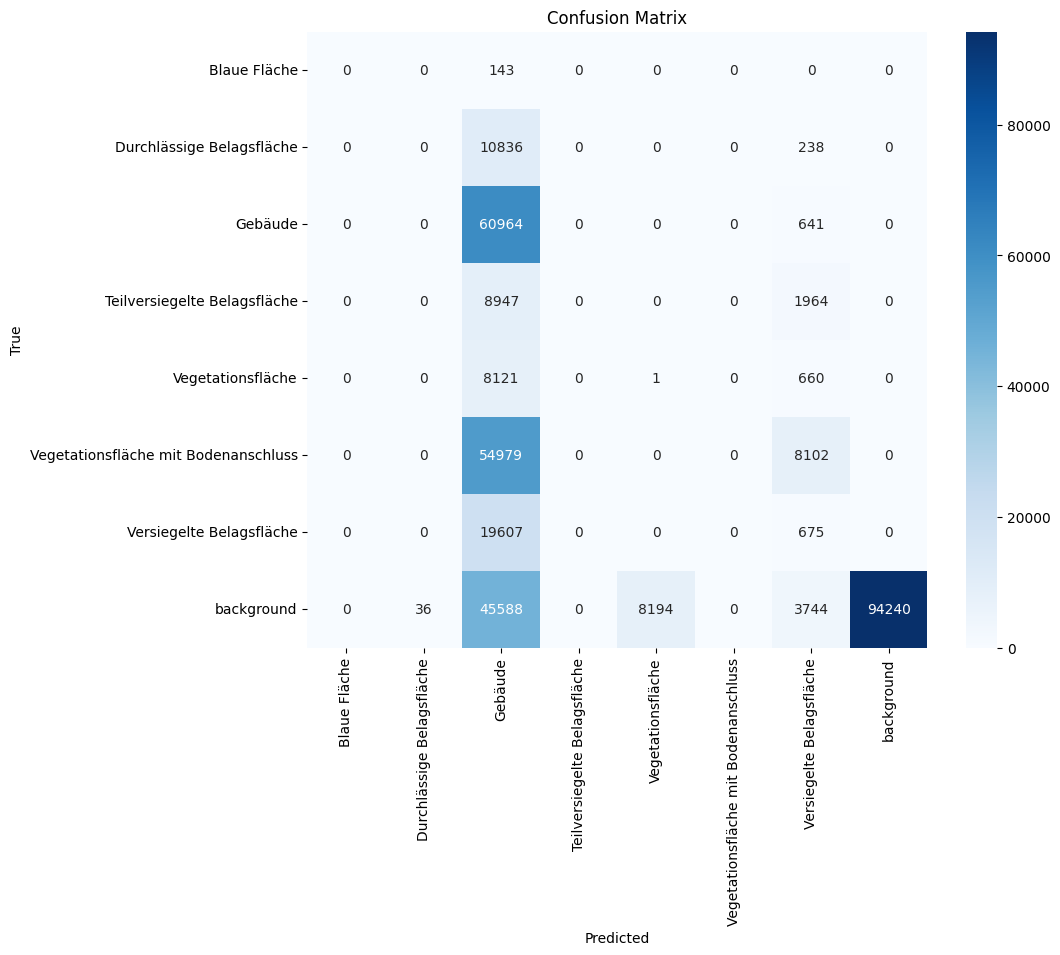

Filtered Labels: [1, 2, 3, 5, 6, 7, 8, 9]
Filtered Class Names: ['Blaue Fläche', 'Durchlässige Belagsfläche', 'Gebäude', 'Teilversiegelte Belagsfläche', 'Vegetationsfläche', 'Vegetationsfläche mit Bodenanschluss', 'Versiegelte Belagsfläche', 'background']
Overall Metrics:
Accuracy: 0.4757
Precision: 0.5207
Recall: 0.4757
F1 Score: 0.4418
Mean IoU: 0.1163
IoU per Class:
Blaue Fläche: 0.0000
Durchlässige Belagsfläche: 0.0000
Gebäude: 0.2905
Teilversiegelte Belagsfläche: 0.0000
Vegetationsfläche: 0.0001
Vegetationsfläche mit Bodenanschluss: 0.0000
Versiegelte Belagsfläche: 0.0189
background: 0.6208


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Laden der Predictions und Ground Truth aus Datei
def load_predictions_and_ground_truth(file_path):
    data = np.load(file_path)
    y_true = data["ground_truths"].flatten()
    y_pred = data["predictions"].flatten()
    return y_true, y_pred

# Filtern der Labels basierend auf y_true und y_pred
def filter_labels(y_true, y_pred, labels, class_names):
    present_labels = set(y_true).union(set(y_pred))  # Alle Klassen, die tatsächlich vorkommen
    filtered_labels = [label for label in labels if label in present_labels]
    filtered_class_names = [class_names[labels.index(label)] for label in filtered_labels]
    return filtered_labels, filtered_class_names

# Konfusionsmatrix berechnen und plotten
def calculate_and_plot_confusion_matrix(y_true, y_pred, labels, class_names):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
    return cm

# Berechnung von Gesamtmetriken und Metriken pro Klasse
def calculate_metrics(y_true, y_pred, labels):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, labels=labels, average="weighted", zero_division=0)
    recall = recall_score(y_true, y_pred, labels=labels, average="weighted", zero_division=0)
    f1 = f1_score(y_true, y_pred, labels=labels, average="weighted", zero_division=0)

    # Berechnung von IoU pro Klasse
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    iou_per_class = []
    for i, label in enumerate(labels):
        intersection = cm[i, i]
        union = sum(cm[i, :]) + sum(cm[:, i]) - intersection
        iou = intersection / union if union != 0 else 0
        iou_per_class.append(iou)
    miou = np.mean(iou_per_class)

    return accuracy, precision, recall, f1, miou, iou_per_class

# Hauptprogramm
file_path = "/content/drive/MyDrive/unet_experiment_5_results_weights.npz"  # Pfad anpassen
labelmap_path = "/content/drive/MyDrive/GroundTruthData/labelmap.txt"  # Pfad zur Labelmap anpassen

# Laden der Predictions und Ground Truth
y_true, y_pred = load_predictions_and_ground_truth(file_path)

# Laden der Labelmap
labelmap = {}
with open(labelmap_path, "r") as file:
    for line in file:
        if not line.startswith("#") and line.strip():
            label, color_rgb, *_ = line.split(":")
            r, g, b = map(int, color_rgb.split(","))
            labelmap[len(labelmap)] = label  # Index als Key, Label als Value

# Labels und Klassennamen extrahieren
labels = list(labelmap.keys())
class_names = list(labelmap.values())

# Labels und Klassennamen filtern
filtered_labels, filtered_class_names = filter_labels(y_true, y_pred, labels, class_names)

# Konfusionsmatrix berechnen und plotten
conf_matrix = calculate_and_plot_confusion_matrix(y_true, y_pred, filtered_labels, filtered_class_names)

# Gesamtmetriken und detaillierte Metriken berechnen
accuracy, precision, recall, f1, miou, iou_per_class = calculate_metrics(y_true, y_pred, filtered_labels)

# Ergebnisse ausgeben
print("Filtered Labels:", filtered_labels)
print("Filtered Class Names:", filtered_class_names)
print("Overall Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Mean IoU: {miou:.4f}")
print("IoU per Class:")
for class_name, iou in zip(filtered_class_names, iou_per_class):
    print(f"{class_name}: {iou:.4f}")

Final y_true length: 2877
Final y_pred length: 2877
Unique classes in y_true_final: {8, 2, 5}
Unique classes in y_pred_final: {8}


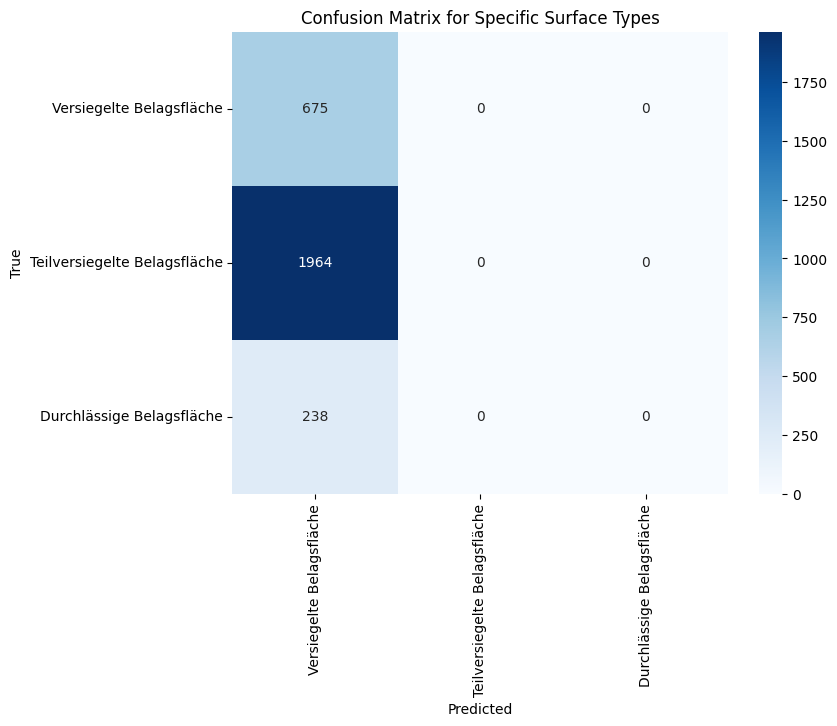

Classification Report for Specific Surface Types:
                               precision    recall  f1-score   support

    Versiegelte Belagsfläche       0.00      0.00      0.00       238
Teilversiegelte Belagsfläche       0.00      0.00      0.00      1964
   Durchlässige Belagsfläche       0.23      1.00      0.38       675

                    accuracy                           0.23      2877
                   macro avg       0.08      0.33      0.13      2877
                weighted avg       0.06      0.23      0.09      2877

Class-Specific IoU Scores for Specific Surface Types:
Versiegelte Belagsfläche: 0.23
Teilversiegelte Belagsfläche: 0.00
Durchlässige Belagsfläche: 0.00


In [ ]:
target_classes_focus = {
    "Versiegelte Belagsfläche": color_to_index[(255, 215, 0)],
    "Teilversiegelte Belagsfläche": color_to_index[(255, 140, 0)],
    "Durchlässige Belagsfläche": color_to_index[(184, 134, 11)]
}

def analyze_specific_classes_unet_consistent(y_true, y_pred, target_classes):
    """
    Analysiert nur die spezifischen Klassen und stellt sicher, dass `y_true` und `y_pred` konsistent sind.
    """
    # Filtere y_true und y_pred basierend auf den Zielklassen
    y_true_filtered = []
    y_pred_filtered = []
    for true_label, pred_label in zip(y_true, y_pred):
        if true_label in target_classes.values():
            y_true_filtered.append(true_label)
            # Füge pred_label nur hinzu, wenn es ebenfalls in den Zielklassen liegt
            y_pred_filtered.append(pred_label if pred_label in target_classes.values() else -1)

    # Entferne alle -1 Klassen (Hintergrund) aus y_pred_filtered
    y_true_final = [t for t, p in zip(y_true_filtered, y_pred_filtered) if p != -1]
    y_pred_final = [p for p in y_pred_filtered if p != -1]

    # Debugging: Überprüfen der Anzahl und Verteilung
    print("Final y_true length:", len(y_true_final))
    print("Final y_pred length:", len(y_pred_final))
    print("Unique classes in y_true_final:", set(y_true_final))
    print("Unique classes in y_pred_final:", set(y_pred_final))

    # Berechnung der Konfusionsmatrix
    adjusted_labels = list(target_classes.values())
    class_names = list(target_classes.keys())
    cm = confusion_matrix(y_true_final, y_pred_final, labels=adjusted_labels)

    # IoU berechnen
    def calculate_class_iou(cm, class_index):
        true_positive = cm[class_index, class_index]
        false_positive = cm[:, class_index].sum() - true_positive
        false_negative = cm[class_index, :].sum() - true_positive
        union = true_positive + false_positive + false_negative
        return true_positive / union if union > 0 else 0

    iou_scores = {class_name: calculate_class_iou(cm, idx) for idx, class_name in enumerate(class_names)}

    # Konfusionsmatrix plotten
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix for Specific Surface Types")
    plt.show()

    # Klassifikationsbericht
    report = classification_report(y_true_final, y_pred_final, target_names=class_names, zero_division=0)
    print("Classification Report for Specific Surface Types:\n", report)

    # IoU-Werte ausgeben
    print("Class-Specific IoU Scores for Specific Surface Types:")
    for class_name, iou in iou_scores.items():
        print(f"{class_name}: {iou:.2f}")

    return cm, iou_scores

# Analyse mit konsistenter Filterung starten
conf_matrix_focus_consistent, class_iou_scores_focus_consistent = analyze_specific_classes_unet_consistent(
    y_true,
    y_pred,
    target_classes_focus
)



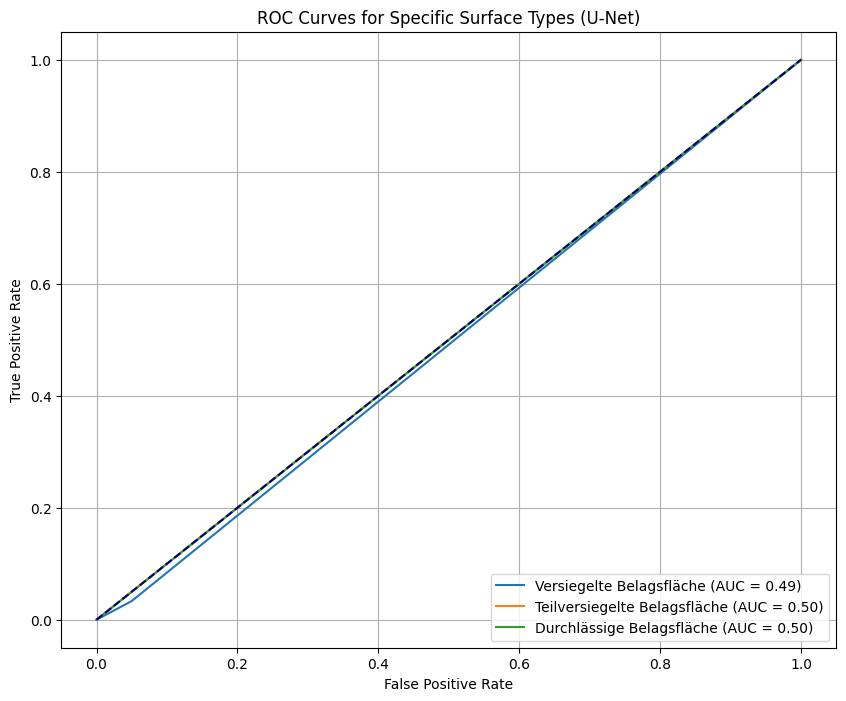

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
import numpy as np

def plot_roc_curves_unet(y_true, y_pred, target_classes):
    """
    Plotte ROC-Kurven für spezifische Flächentypen.
    """
    # Zielklassen-Labels und Namen
    target_labels = list(target_classes.values())
    class_names = list(target_classes.keys())

    # Binarisiere die Ground-Truth-Werte für One-vs-All-ROC
    y_true_binarized = label_binarize(y_true, classes=target_labels)

    # Initialisierung für die Kurven
    plt.figure(figsize=(10, 8))
    for i, class_index in enumerate(target_labels):
        if class_index not in target_labels:
            continue
        # Filtere vorhergesagte Wahrscheinlichkeiten für die aktuelle Klasse
        class_probs = (np.array(y_pred) == class_index).astype(int)  # Binäre Wahrscheinlichkeiten

        # Berechne FPR, TPR und AUC für die aktuelle Klasse
        fpr, tpr, _ = roc_curve(y_true_binarized[:, i], class_probs)
        roc_auc = auc(fpr, tpr)

        # Plotten der ROC-Kurve
        plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

    # ROC-Kurven Formatierung
    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")  # Diagonale Linie
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves for Specific Surface Types (U-Net)")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

# Zielklassen (Fokus auf Flächentypen)
target_classes_focus = {
    "Versiegelte Belagsfläche": color_to_index[(255, 215, 0)],
    "Teilversiegelte Belagsfläche": color_to_index[(255, 140, 0)],
    "Durchlässige Belagsfläche": color_to_index[(184, 134, 11)]
}

# ROC-Kurve für die spezifischen Klassen plotten
plot_roc_curves_unet(y_true, y_pred, target_classes_focus)
